In [2]:
from IPython.display import Image

from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm
import os
import numpy as np
import pandas as pd


In [3]:
device = 'cuda'

Чтобы в будущем делать оптимальный ресайз, нужно понимать среднее разрешение фотографий

In [4]:
folder_path = "./dataset/train"

total_width = 0
total_height = 0
total_images = 0

for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Фильтруем изображения по расширениям
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            total_width += width
            total_height += height
            total_images += 1

if total_images > 0:
    WIDTH = total_width / total_images
    HEIGHT = total_height / total_images
    print(f"Average Width: {WIDTH} pixels")
    print(f"Average Height: {HEIGHT} pixels")
else:
    print("No images found in the specified folder.")

WIDTH = int(0.7 * WIDTH) # 15% пикселей слева и справа не несут никакой информации, но при этом часто туда попадаются нежелательные инородные объекты
HEIGHT = int(1.0 * HEIGHT)

Average Width: 48.2663 pixels
Average Height: 27.2345 pixels


Функция пересчета MSE для всех пикселей

In [5]:
def calculate_mse(image1, image2):
    mse = F.mse_loss(image1, image2, reduction='mean')
    return mse.item()

Реализация чтения датасета для DataLoader. Из особенностей можно заметить, что внутру мы расщипляем изображение на цвета и для работы забираем только красный

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_list = os.listdir(root_dir)

        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((HEIGHT, WIDTH)),
            transforms.GaussianBlur(7, 0.5),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name).convert("RGB")

        new_width = int(image.width * 0.7)
        left = int((image.width - new_width) / 2)
        right = left + new_width
        image = image.crop((left, 0, right, image.height))
        
        blue_channel = image.split()[0]
        gray_blue_channel = blue_channel.convert("L")
        image = self.transform(gray_blue_channel)
    
        return image, img_name

Автоэнкодер

In [7]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(HEIGHT * WIDTH, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, HEIGHT * WIDTH)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, HEIGHT, WIDTH))
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for img, img_name in data:
            x = img.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

latent_dims = 2
autoencoder = VariationalAutoencoder(latent_dims).to(device)

Создание датасета

In [8]:
train_data_path = "./dataset/train"
train_dataset = CustomDataset(root_dir=train_data_path)
train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=10000,
        shuffle=True)

Тренировка автоэнкодера на непроливах

In [9]:
model = train(autoencoder, train_dataloader, epochs=40).to(device)
model.eval()

100%|██████████| 40/40 [02:11<00:00,  3.30s/it]


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=891, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=891, bias=True)
  )
)

Выведем исходное и получившееся изображение

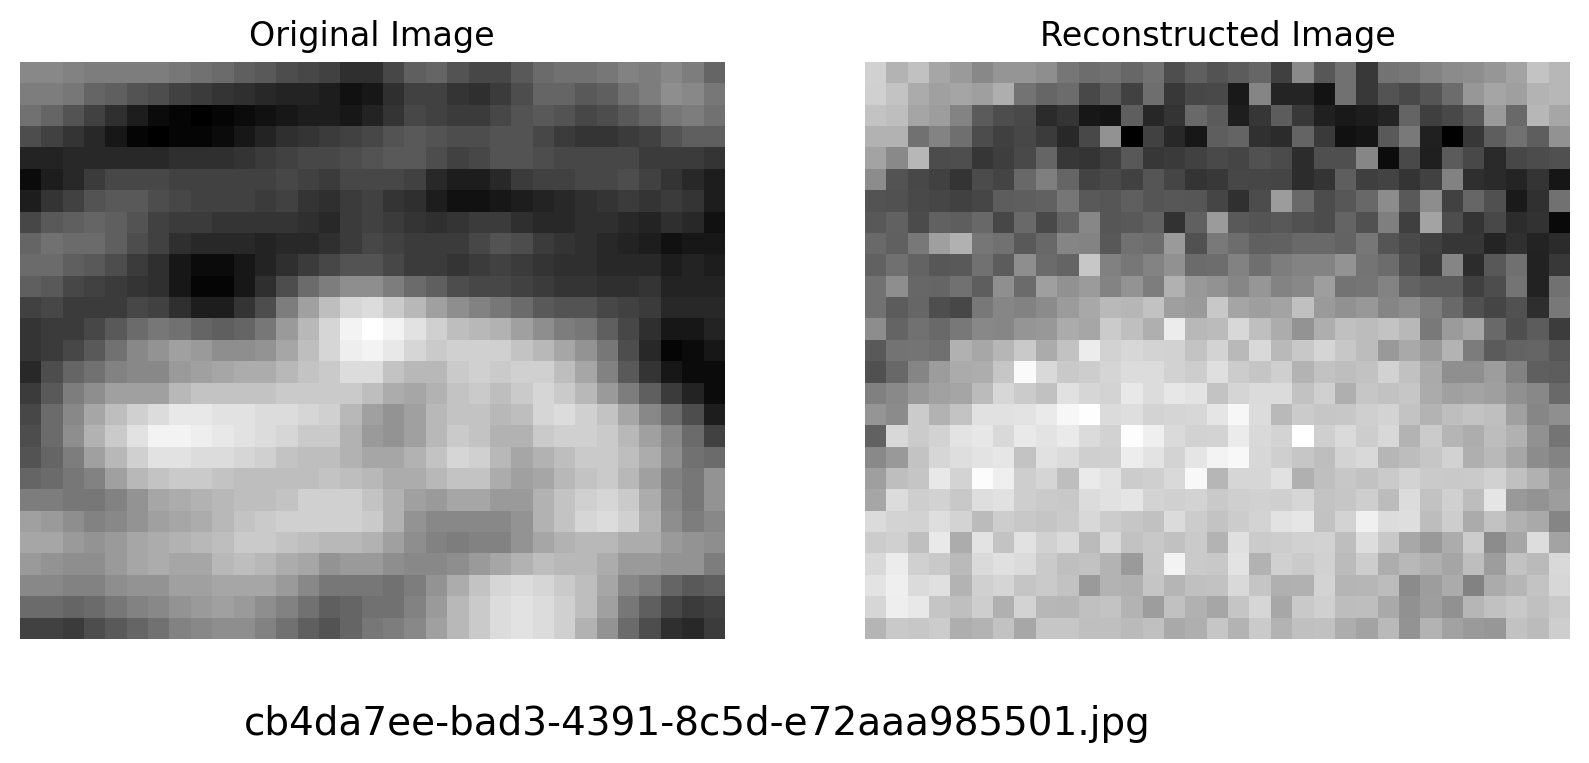

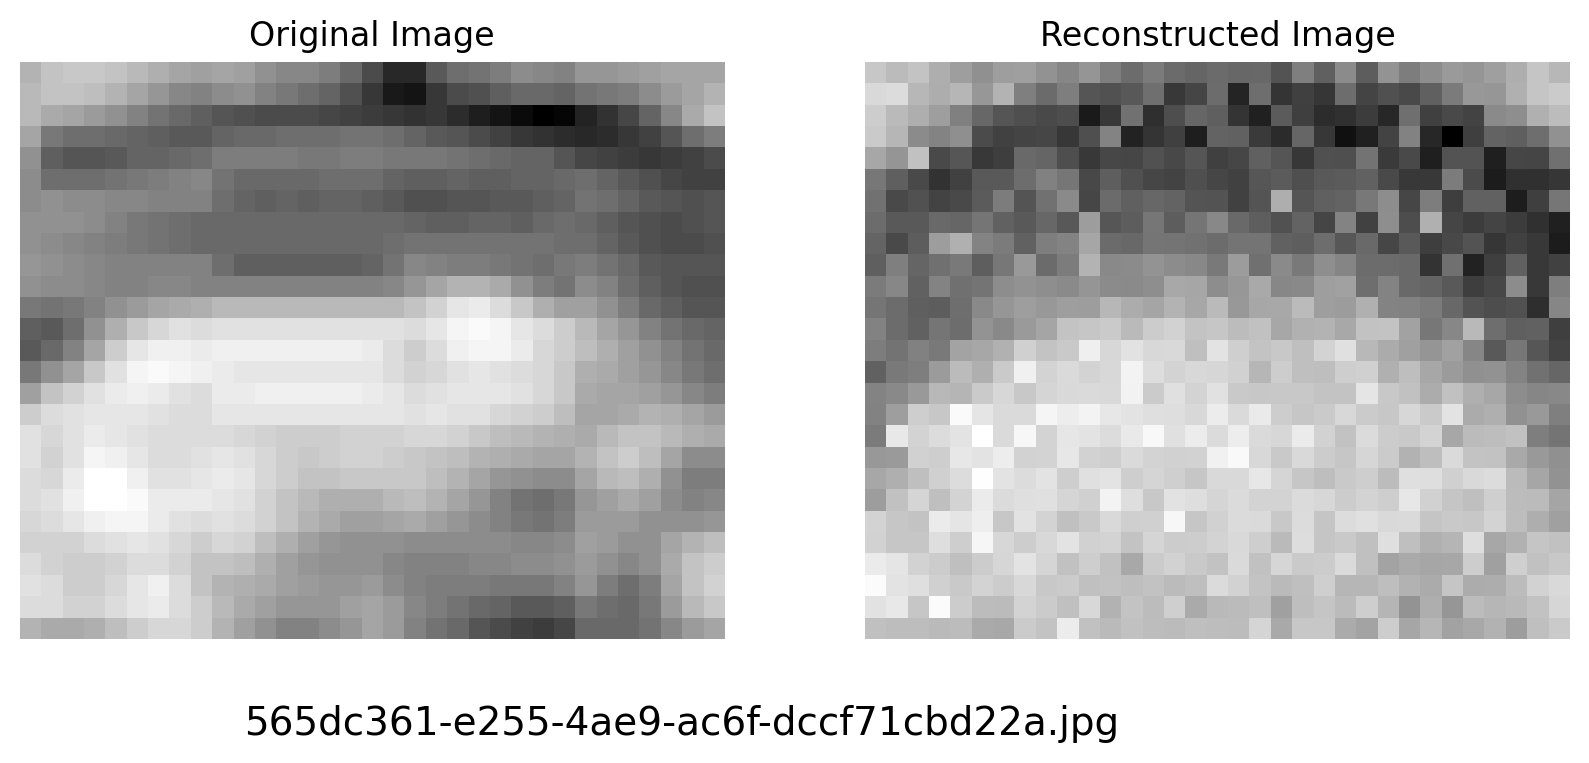

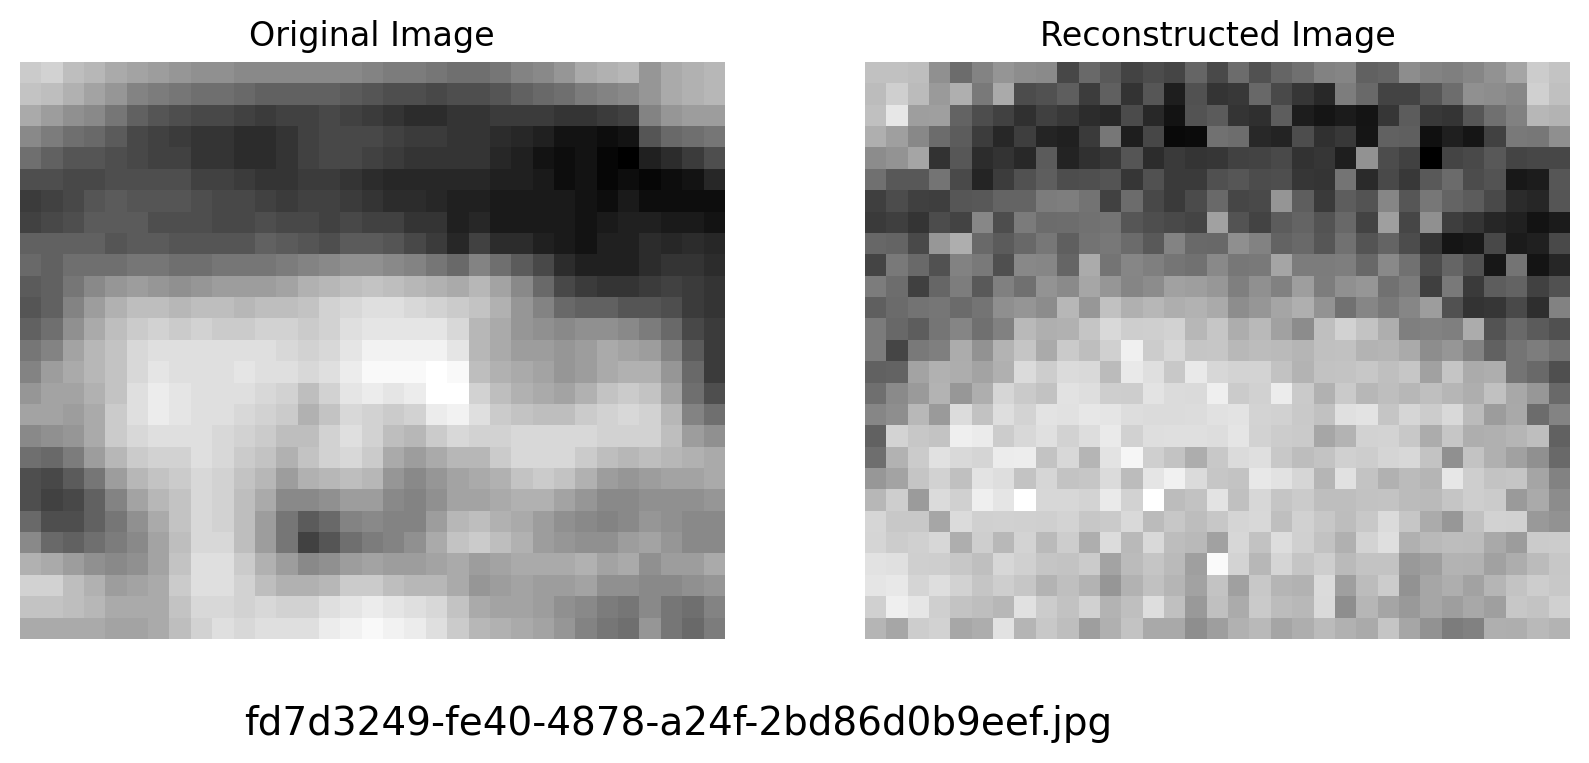

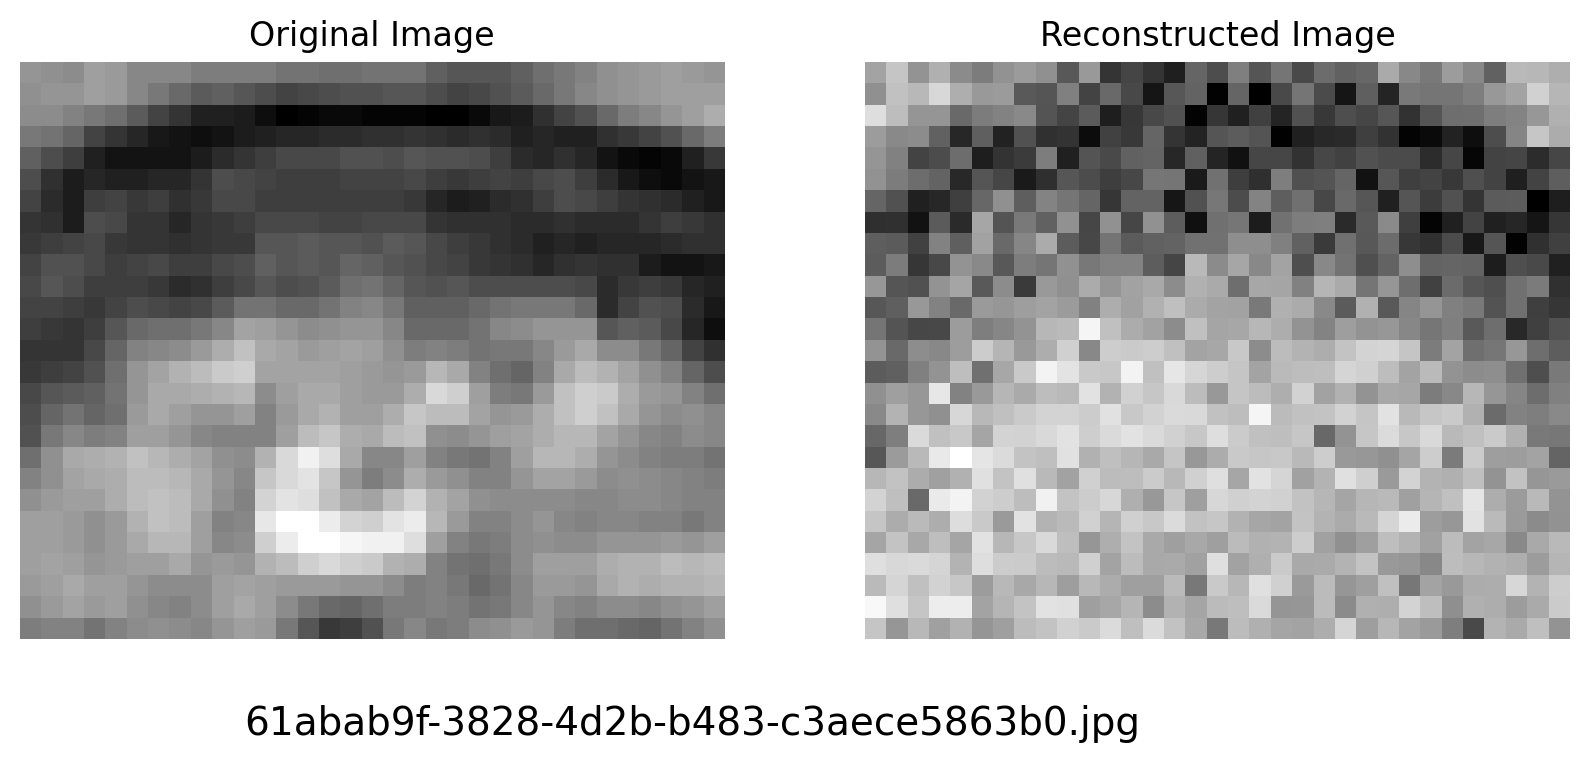

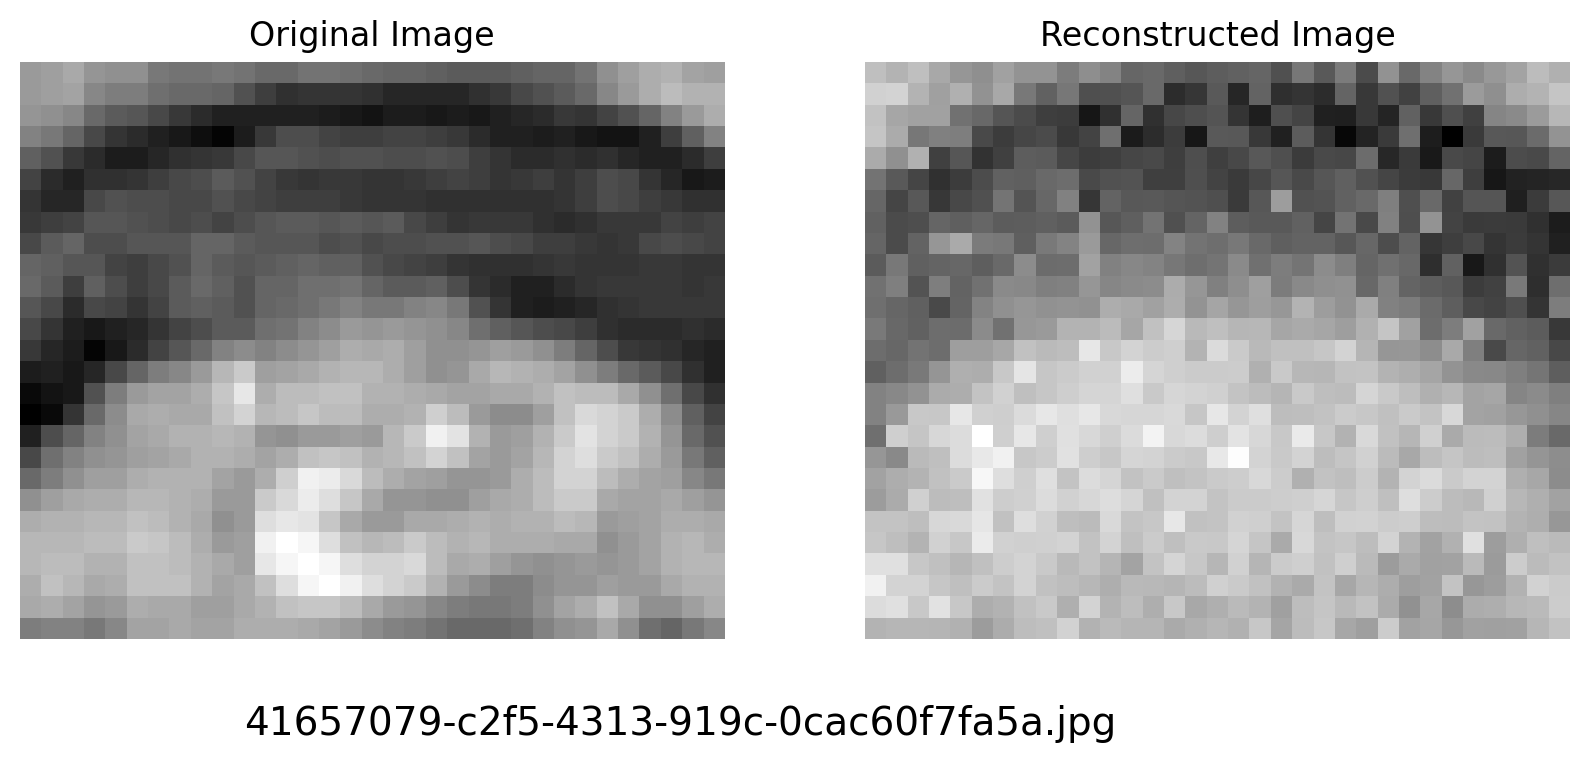

In [10]:
# Получите несколько изображений из тестового датасета
with torch.no_grad():
    for img, img_name in train_dataloader:
        original_images = img.to(device)

        reconstructed_images = model(original_images)  # Восстановленные изображения

        # Выведите несколько изображений (оригинал и восстановленный)
        for i in range(5):  # Вывести первые 5 изображений из пакета
            plt.figure(figsize=(10, 5))

            # Оригинал
            plt.subplot(1, 2, 1)
            plt.imshow(original_images[i][0].cpu().numpy(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.text(10, HEIGHT+4, img_name[i].split('/')[-1], color='black', fontsize=14)
            
            # Восстановленный
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_images[i][0].cpu().numpy(), cmap='gray')
            plt.title('Reconstructed Image')
            plt.axis('off')
            
            plt.show()

        break

Сохраним список всех MSE для нормальных изображений

In [11]:
images_mse = []

with torch.no_grad():
    for img, img_name in train_dataloader:
        original_images = img.to(device)

        reconstructed_images = model(original_images)
        
        for i in range(len(original_images)):
            images_mse.append(calculate_mse(original_images[i], reconstructed_images[i]))

Функция вывода плотности распределения MSE

In [12]:
from scipy.stats import norm

def get_stat(images_mse):
    
    print(f"MIN_MSE_PROL: {MIN_MSE_PROL:.5f}")
    print(f"len train: {len(images_mse)}")
    print(f"problem train: {len([num for num in images_mse if num > MIN_MSE_PROL])}")
    print(f"error train: {len([num for num in images_mse if num > MIN_MSE_TRASH])}")
    print(f"max train MSE: {max(images_mse):.5f}")
    print(f"min train MSE: {min(images_mse):.5f}")
    
    # Постройте гистограмму распределения
    plt.hist(images_mse, bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
    
    # Вычислите параметры нормального распределения (среднее и стандартное отклонение)
    mu, std = norm.fit(images_mse)
    
    # Постройте график плотности вероятности
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    # Настройте оформление
    plt.title('Distribution of Values with Probability Density Function')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Покажите график
    plt.show()

Просмотр статистики и ручная установка границ. 
MIN_MSE_PROL - граница, после которой считаем, что на картинке пролив
MIN_MSE_TRASH - граница, после которой считаем, что инородний объект загородил камеру, в таком случае будем считать, что аномалии нет

MIN_MSE_PROL: 0.00336
len train: 10000
problem train: 408
error train: 7
max train MSE: 0.01529
min train MSE: 0.00032


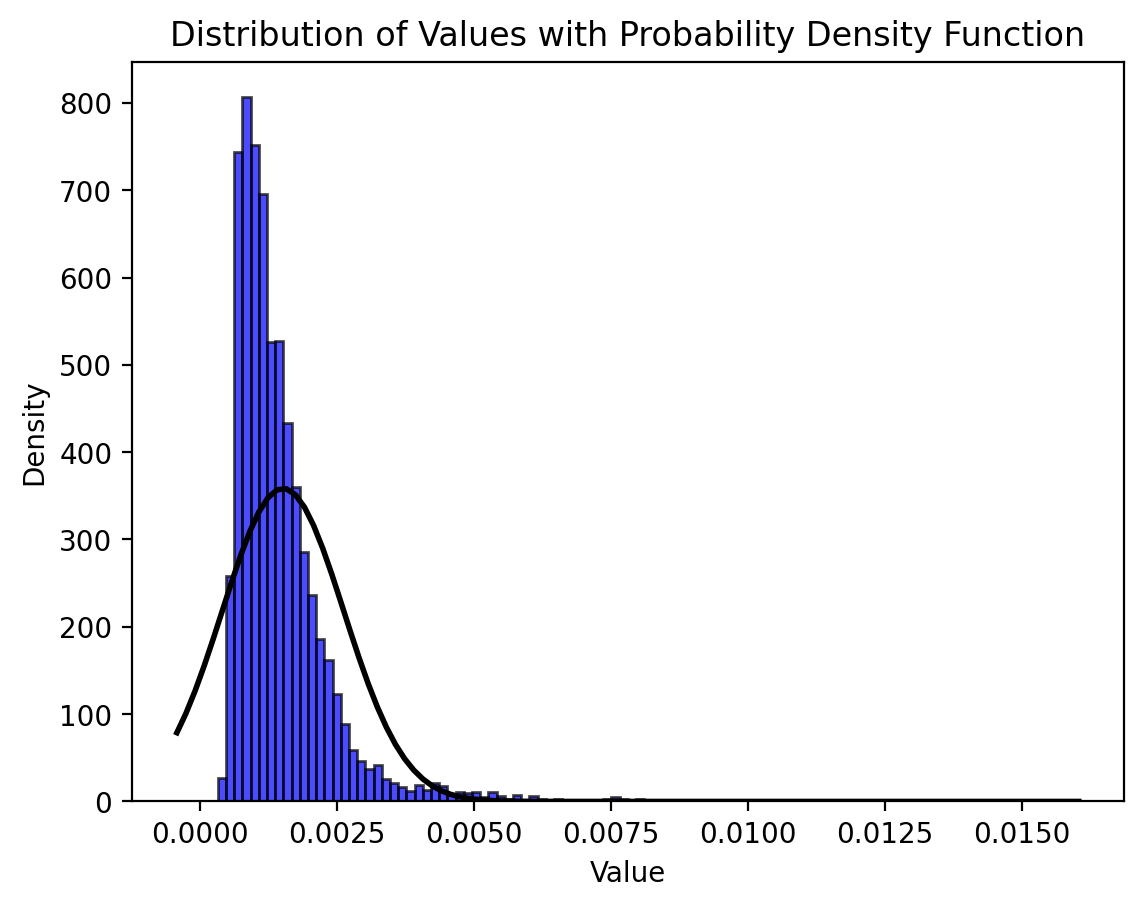

In [50]:
MIN_MSE_PROL = max(images_mse) * 0.22 # Подбираем руками чтобы "problem train" было не больше 900
MIN_MSE_TRASH = max(images_mse) * 0.9

get_stat(images_mse)

Создаем датасет проливов

In [51]:
proliv_data_path = "./dataset/proliv"
proliv_dataset = CustomDataset(root_dir=proliv_data_path)
proliv_dataloader = torch.utils.data.DataLoader(dataset=proliv_dataset, batch_size=10000)

Сохраняем список MSE для проливов

In [52]:
images_mse_proliv = []

with torch.no_grad():
    for img, img_name in proliv_dataloader:
        original_images = img.to(device)

        reconstructed_images = model(original_images)
        
        for i in range(len(original_images)):
            images_mse_proliv.append(calculate_mse(original_images[i], reconstructed_images[i]))

Выведем все изображения исходных проливов и получившихся после автоэнкодера 

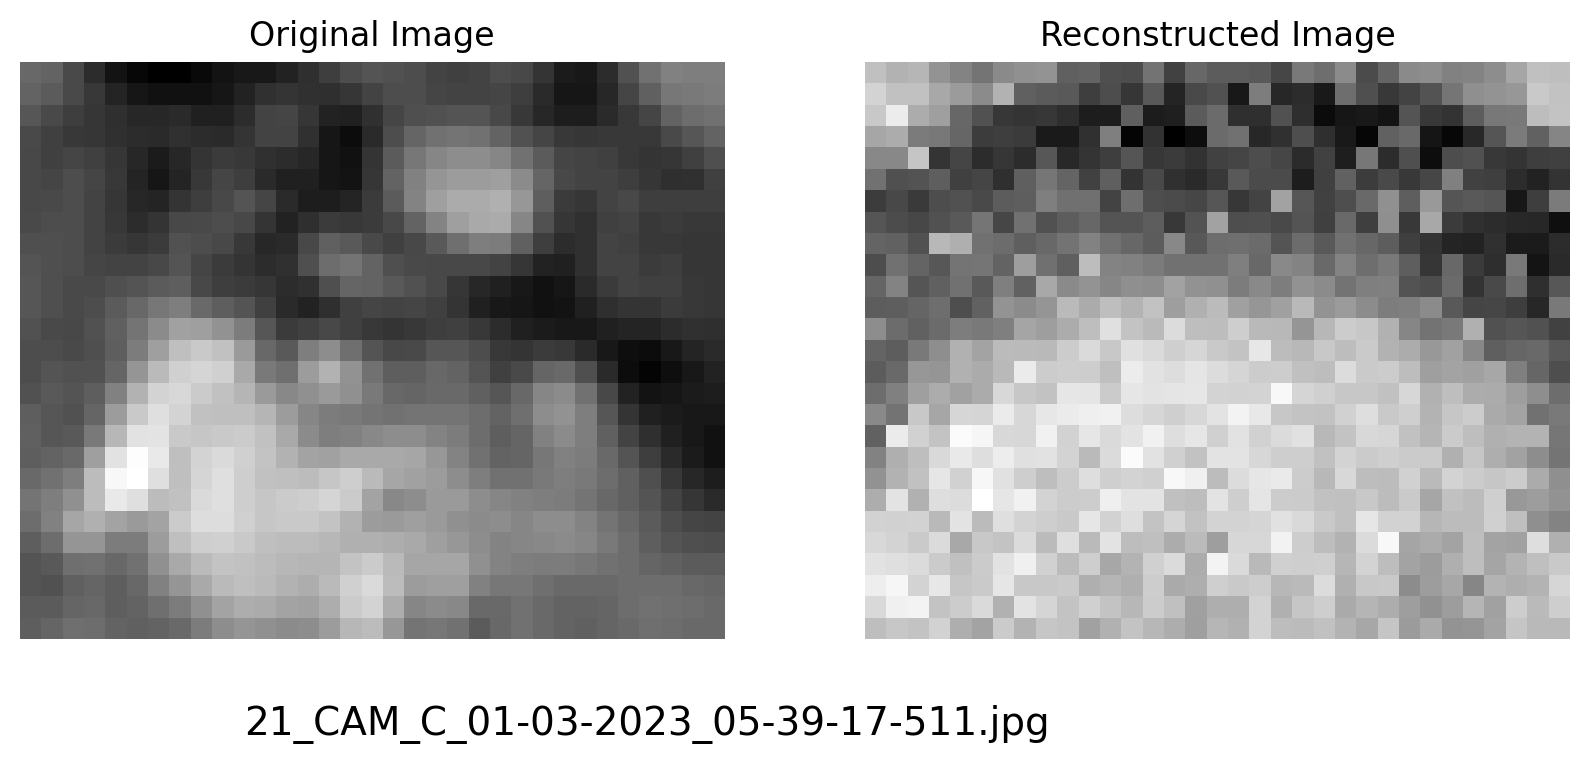

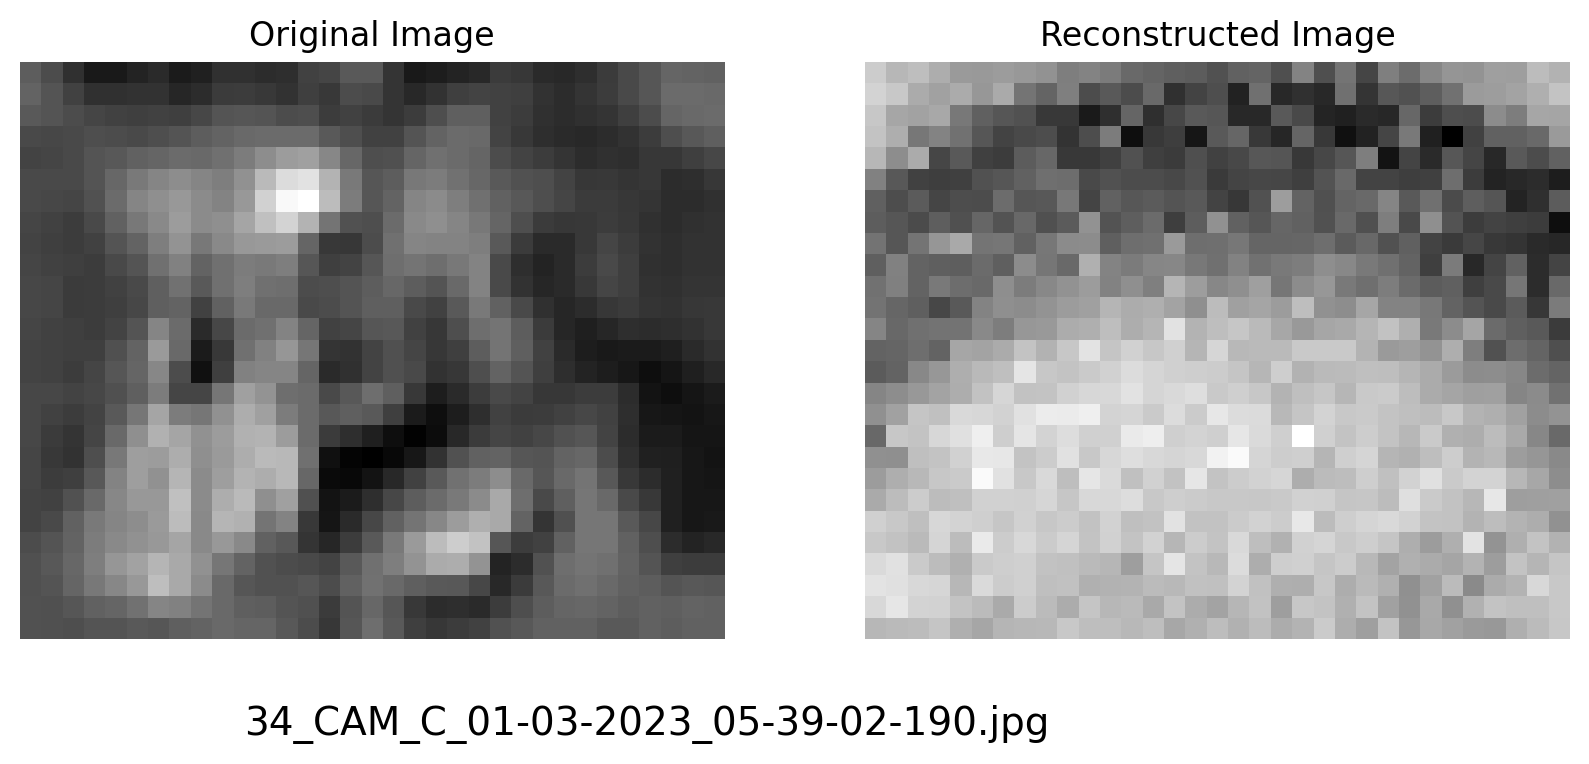

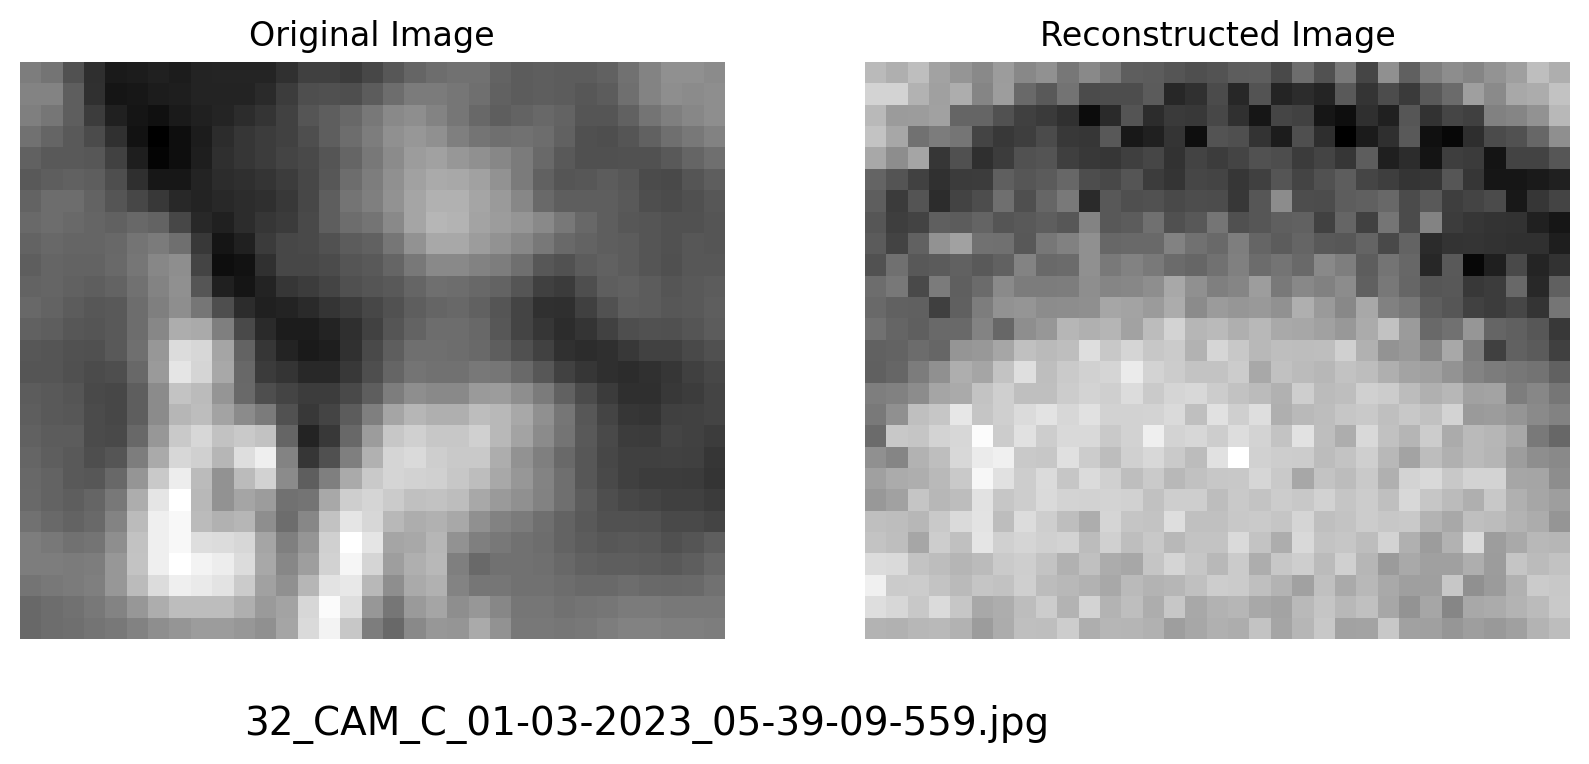

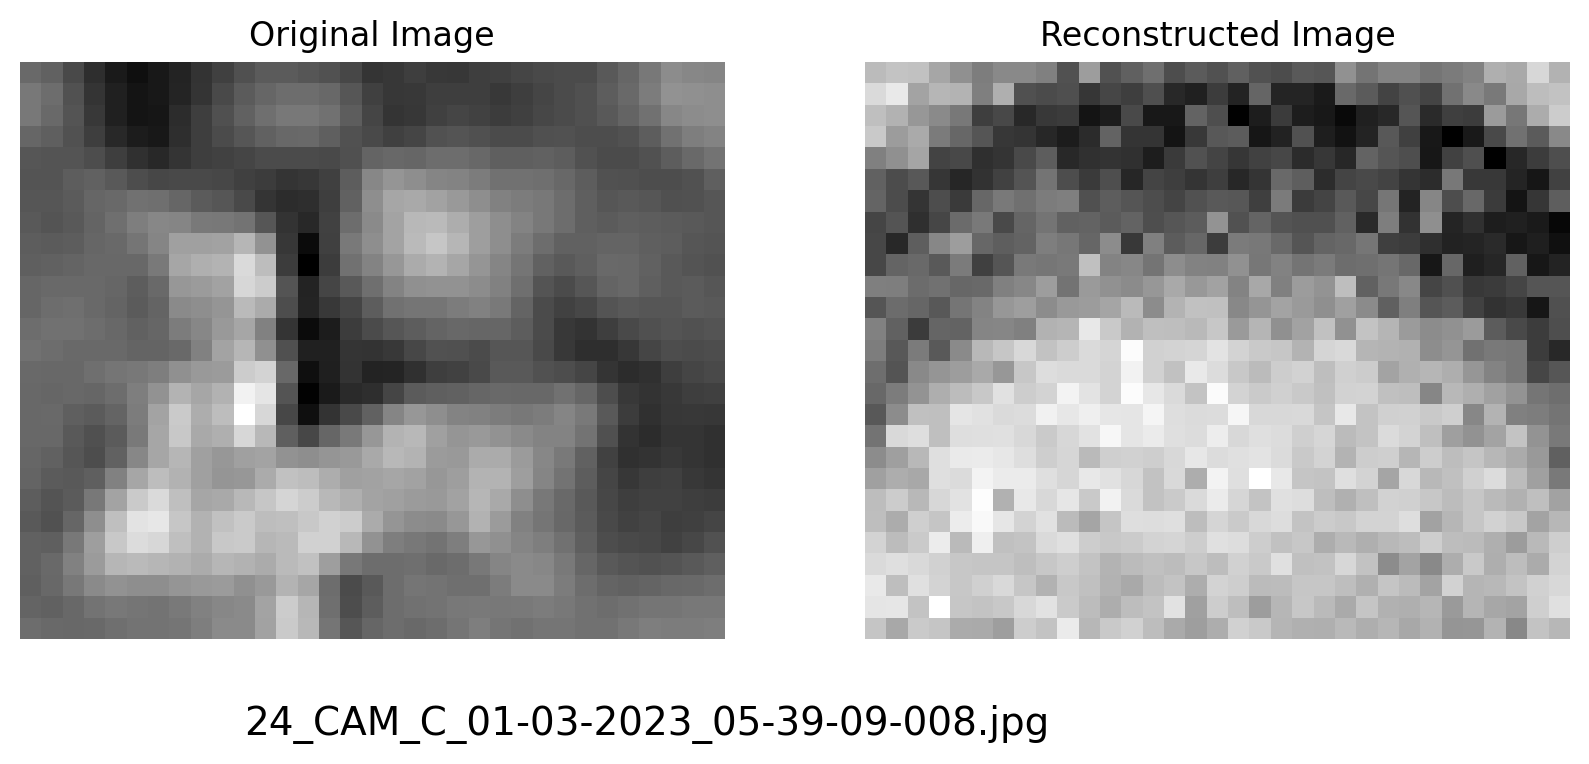

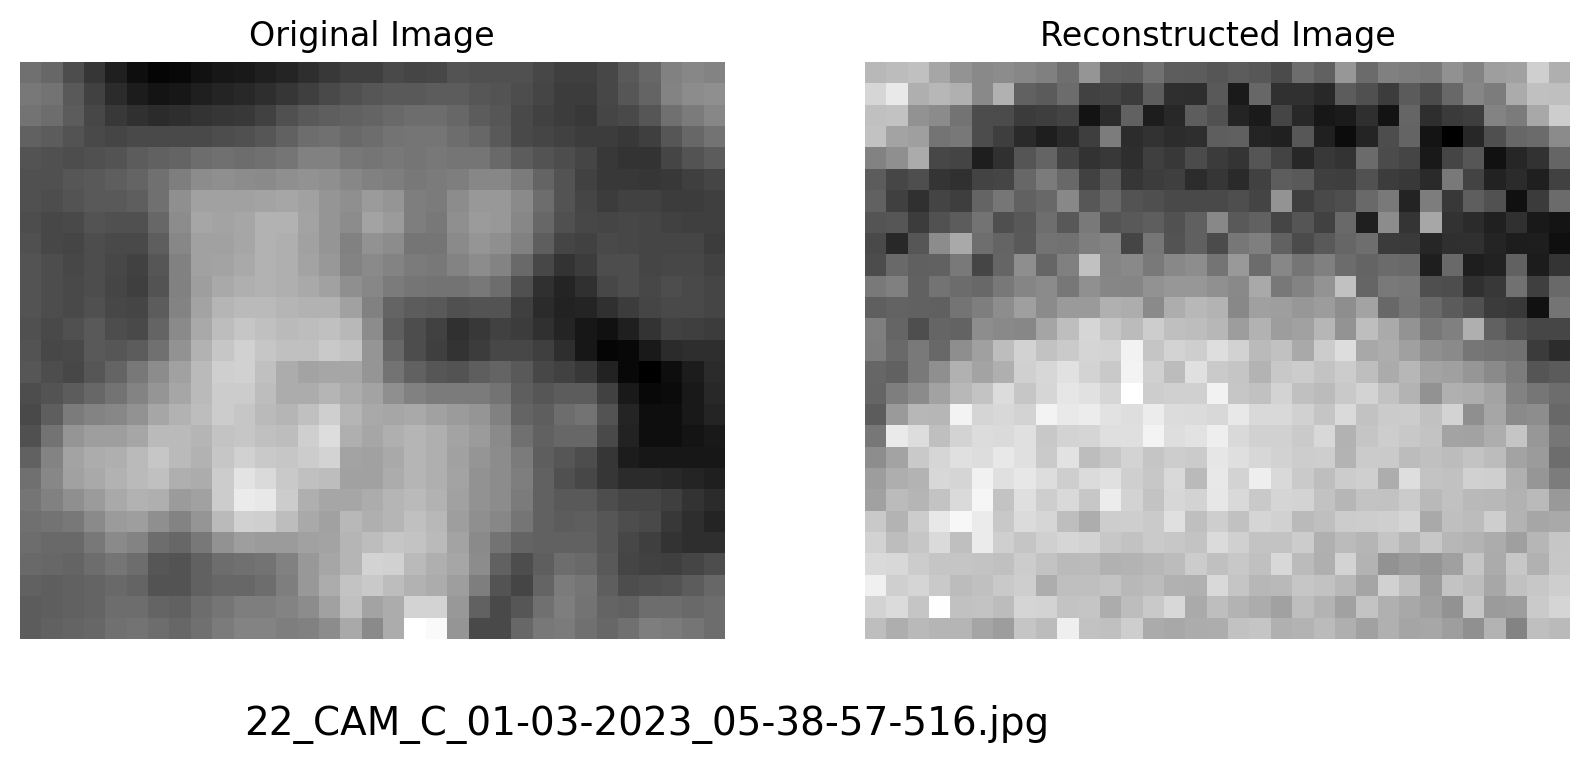

In [53]:
# Получите несколько изображений из тестового датасета
with torch.no_grad():
    for img, img_name in proliv_dataloader:
        original_images = img.to(device)

        reconstructed_images = model(original_images)  # Восстановленные изображения

        # Выведите несколько изображений (оригинал и восстановленный)
        for i in range(5):  # Вывести первые 5 изображений из пакета
            plt.figure(figsize=(10, 5))

            # Оригинал
            plt.subplot(1, 2, 1)
            plt.imshow(original_images[i][0].cpu().numpy(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.text(10, HEIGHT+4, img_name[i].split('/')[-1], color='black', fontsize=14)
            
            # Восстановленный
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_images[i][0].cpu().numpy(), cmap='gray')
            plt.title('Reconstructed Image')
            plt.axis('off')
            
            plt.show()

        break

Вывод статистики по проливам, на осново которой можно вернуться к коэффициаентам MIN_MSE_PROL и MIN_MSE_TRASH и подрегулировать их

MIN_MSE_PROL: 0.00336
len train: 154
problem train: 154
error train: 0
max train MSE: 0.01075
min train MSE: 0.00393


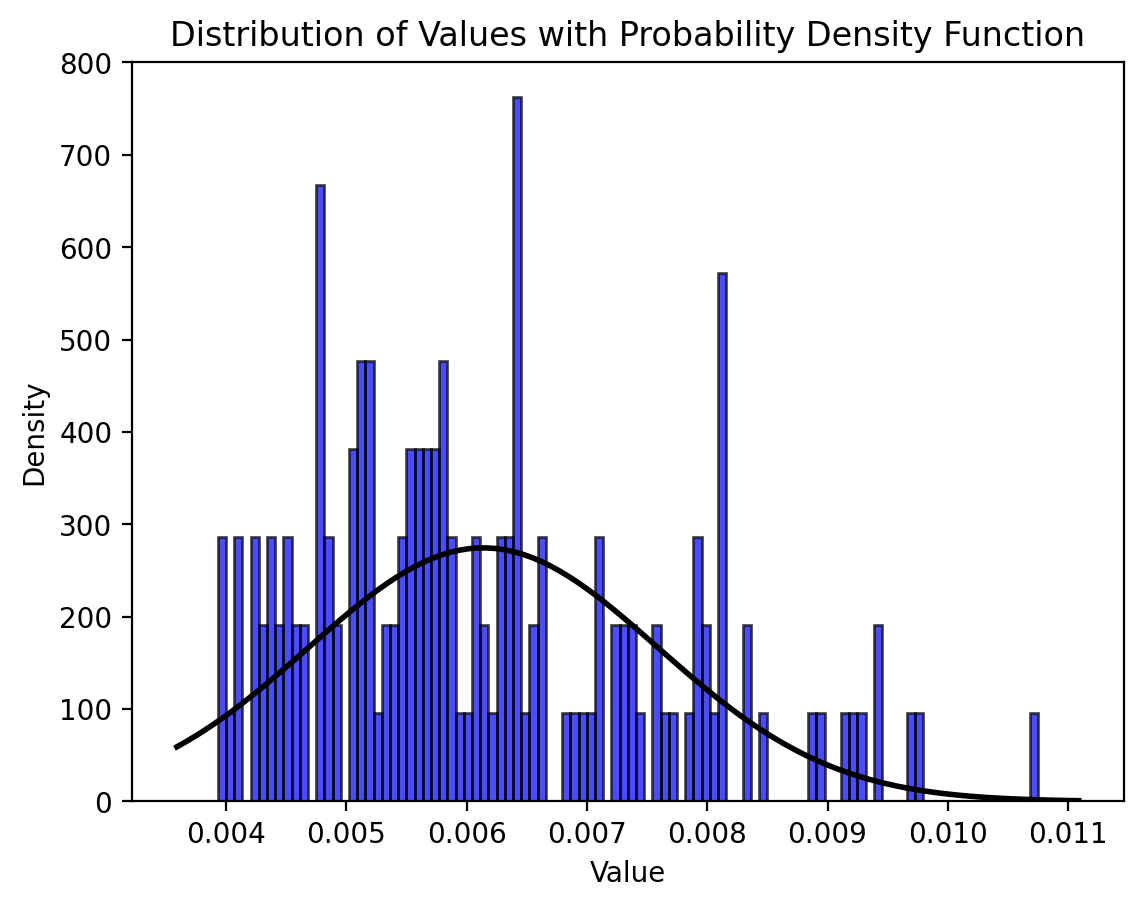

In [54]:
get_stat(images_mse_proliv)

In [55]:
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, annotation_file):
        self.images_dir = os.path.join(root_dir, "imgs")
        self.annotations = pd.read_csv(os.path.join(root_dir, annotation_file), delimiter=' ', header=None, names=['filename', 'label'])
        self.image_list = os.listdir(self.images_dir)
        
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((HEIGHT, WIDTH)),
            transforms.GaussianBlur(7, 0.5),    
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_list[idx])
        image = Image.open(img_name).convert("RGB")
        
        new_width = int(image.width * 0.7)
        left = int((image.width - new_width) / 2)
        right = left + new_width
        image = image.crop((left, 0, right, image.height))
        
        blue_channel = image.split()[0]
        gray_blue_channel = blue_channel.convert("L")
        image = self.transform(gray_blue_channel)

        label = self.annotations[self.annotations["filename"].isin([self.image_list[idx]])]["label"].iloc[0]
        return image, img_name, label

Создание тестового датасета

In [56]:
test_data_path = "./dataset/test"
annotation_file = "test_annotation.txt"
test_dataset = CustomTestDataset(root_dir=test_data_path, annotation_file=annotation_file)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000)

Просмотр изображений из тестового датасета

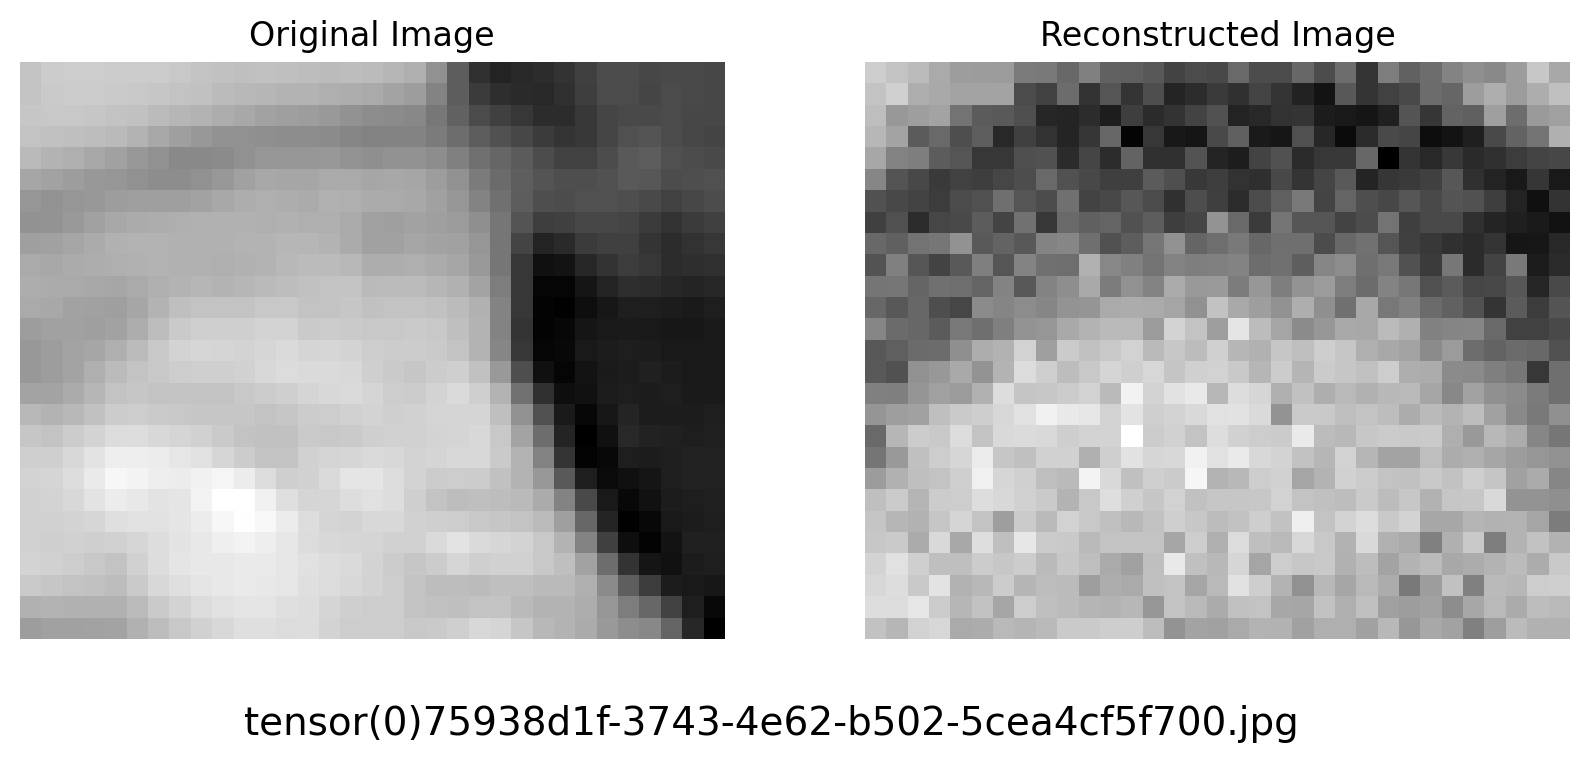

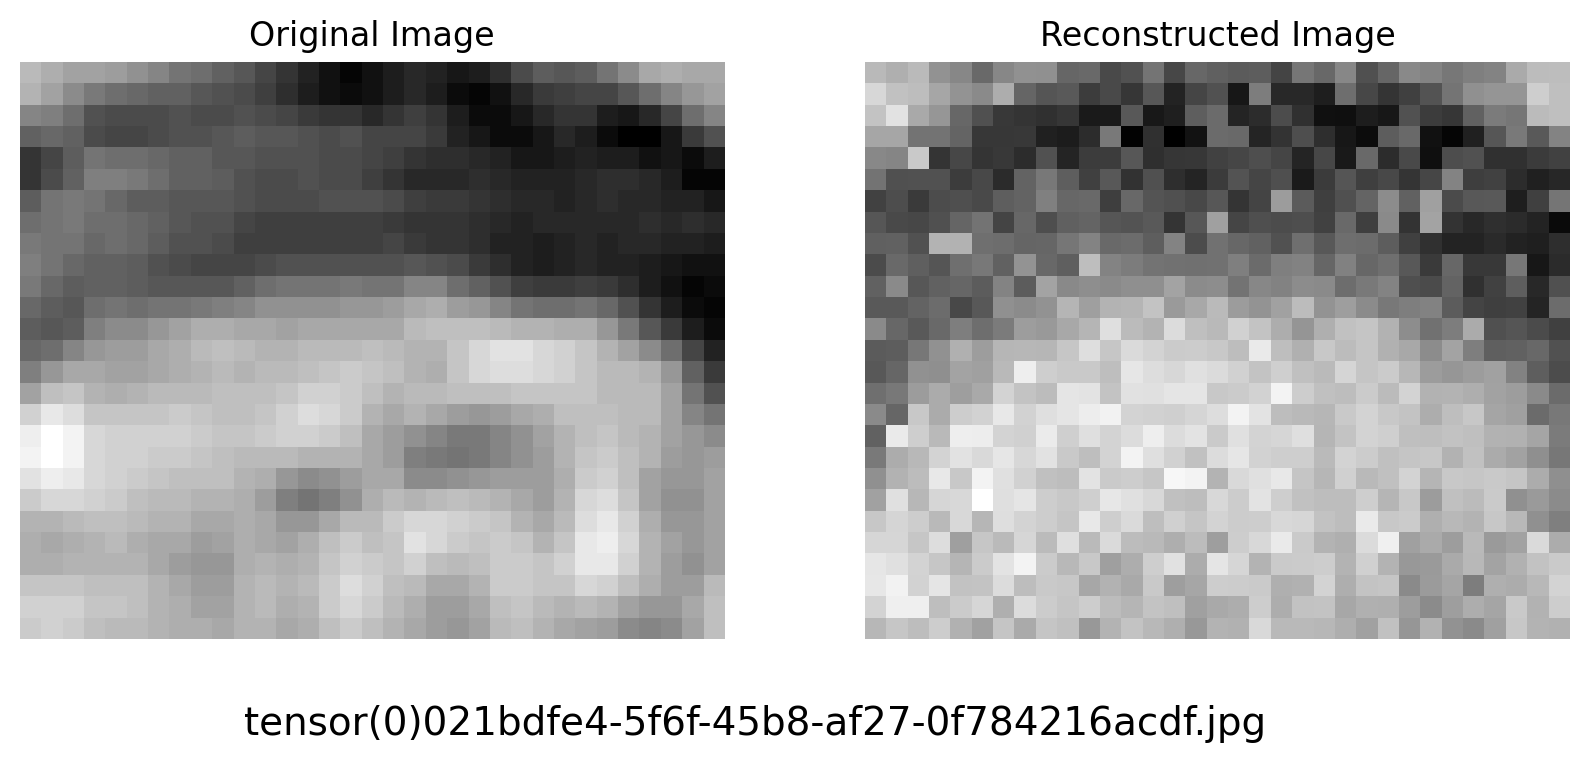

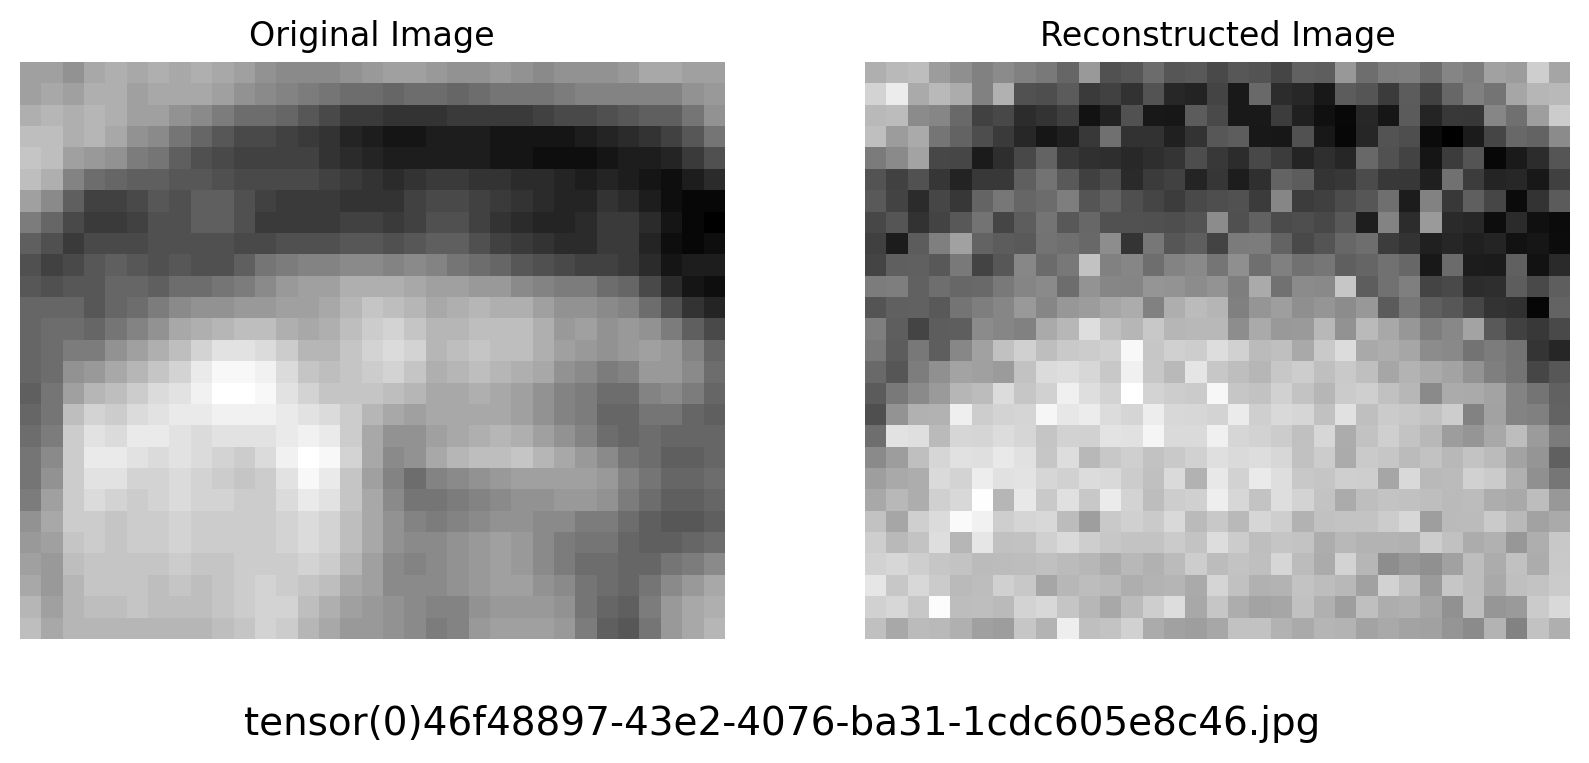

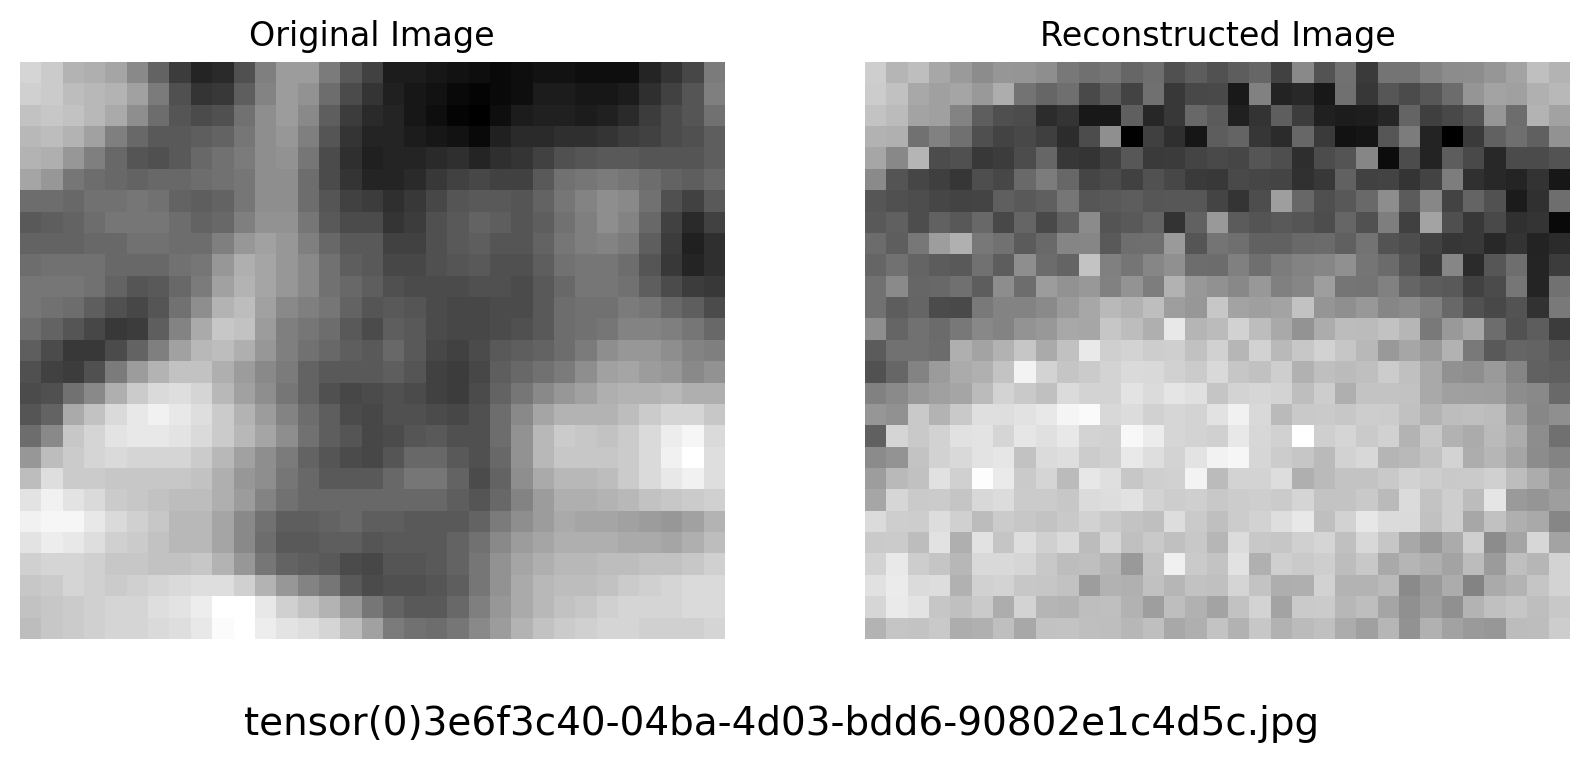

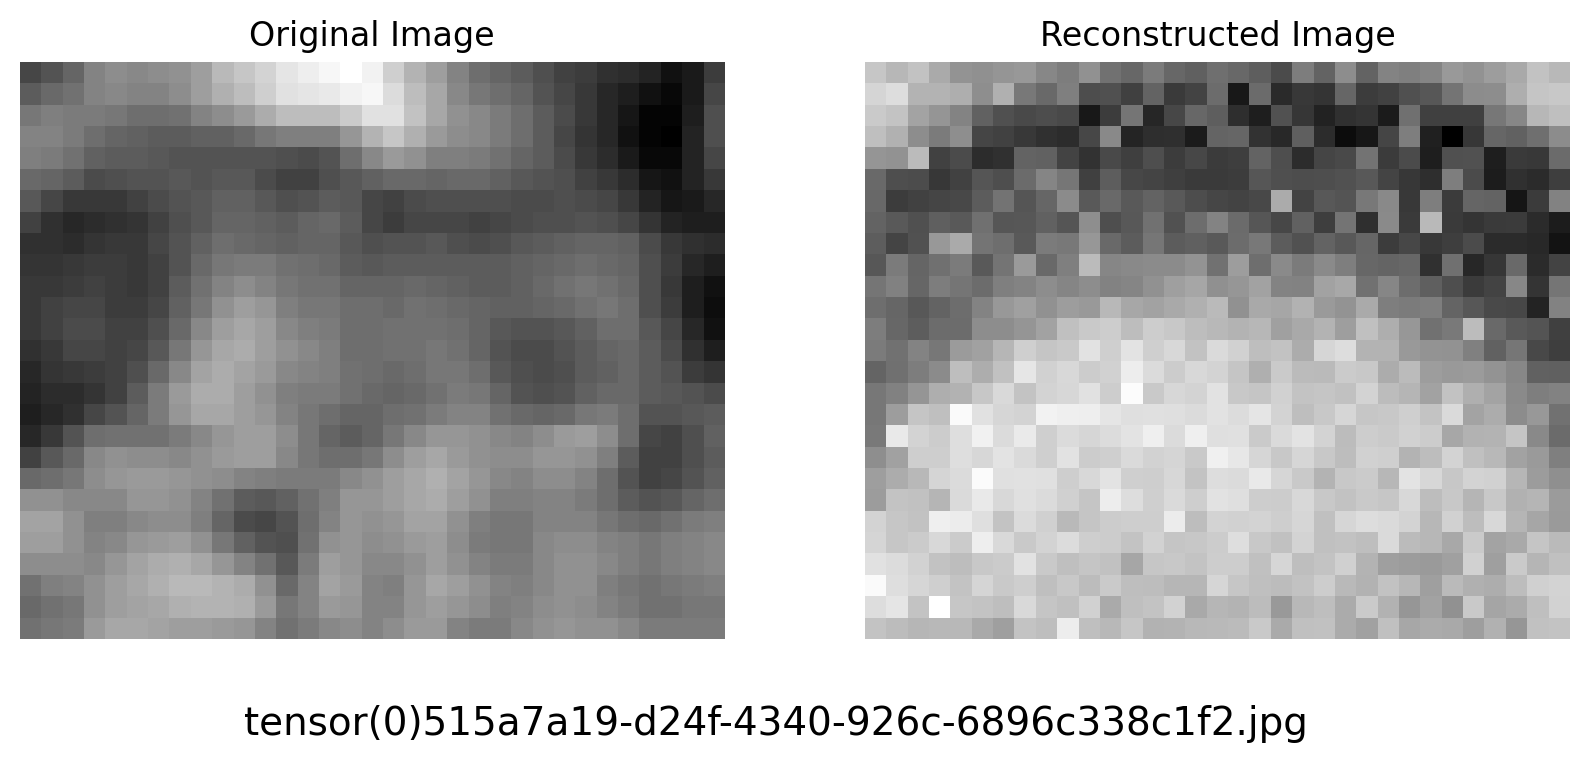

In [57]:
# Получите несколько изображений из тестового датасета
with torch.no_grad():
    for img, img_name, label in test_dataloader:
        original_images = img.to(device)

        reconstructed_images = model(original_images)  # Восстановленные изображения

        # Выведите несколько изображений (оригинал и восстановленный)
        for i in range(5):  # Вывести первые 5 изображений из пакета
            plt.figure(figsize=(10, 5))

            # Оригинал
            plt.subplot(1, 2, 1)
            plt.imshow(original_images[i][0].cpu().numpy(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.text(10, HEIGHT+4, str(label[i])+ img_name[i].split('/')[-1], color='black', fontsize=14)
            
            # Восстановленный
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_images[i][0].cpu().numpy(), cmap='gray')
            plt.title('Reconstructed Image')
            plt.axis('off')
            
            plt.show()

        break

Заполнение массивов MSE для аномальных и нормальных изображений

In [58]:
images_mse_anom = []
images_mse_norm = []

with torch.no_grad():
    for img, img_name, labels in test_dataloader:
        original_images = img.to(device)
        reconstructed_images = model(original_images)
        
        for i in range(len(original_images)):
            mse = calculate_mse(original_images[i], reconstructed_images[i])
        
            if (labels[i] == 1):
                images_mse_anom.append(mse)
            else:
                 images_mse_norm.append(mse)

Статистика для аномалий

MIN_MSE_PROL: 0.00336
len train: 129
problem train: 116
error train: 0
max train MSE: 0.01309
min train MSE: 0.00220


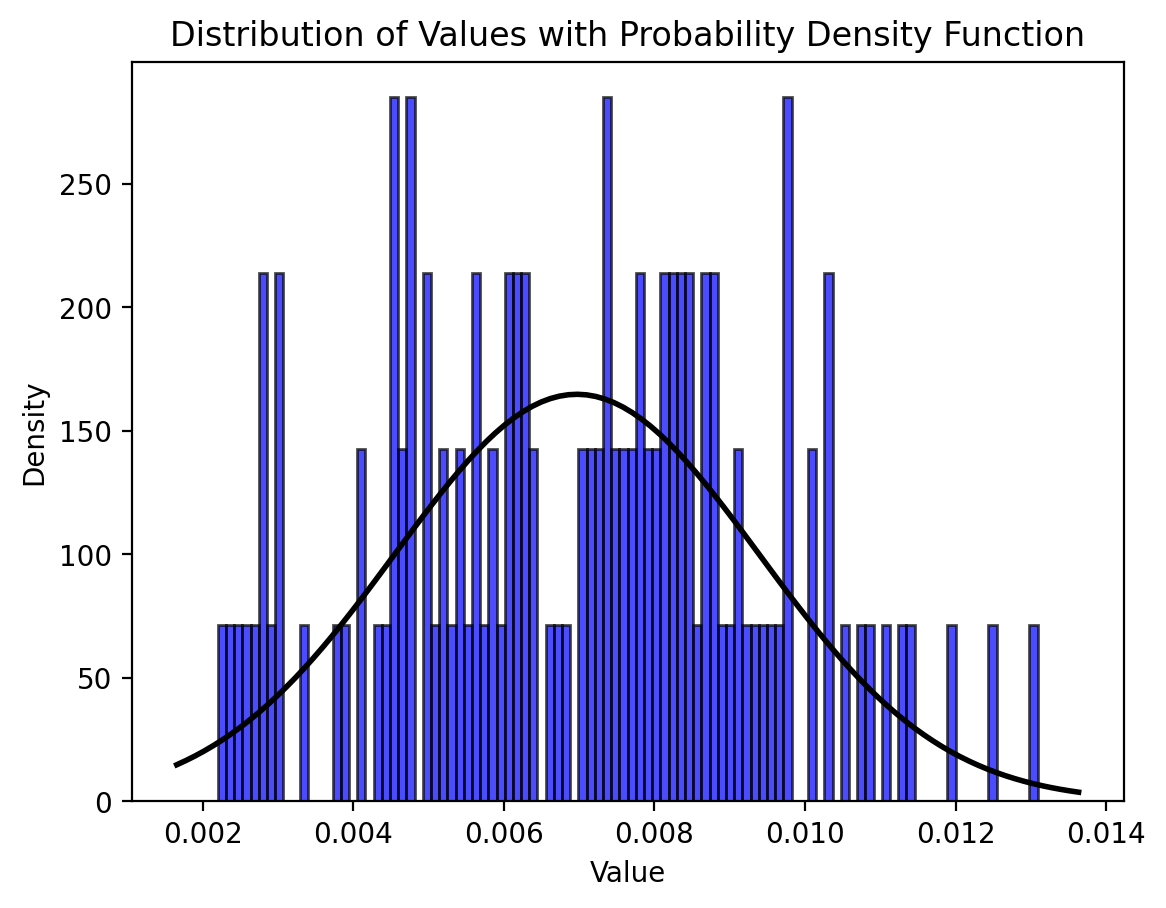

In [59]:
get_stat(images_mse_anom)

Статистика для нормальных цилиндров

MIN_MSE_PROL: 0.00336
len train: 3665
problem train: 347
error train: 17
max train MSE: 0.03144
min train MSE: 0.00041


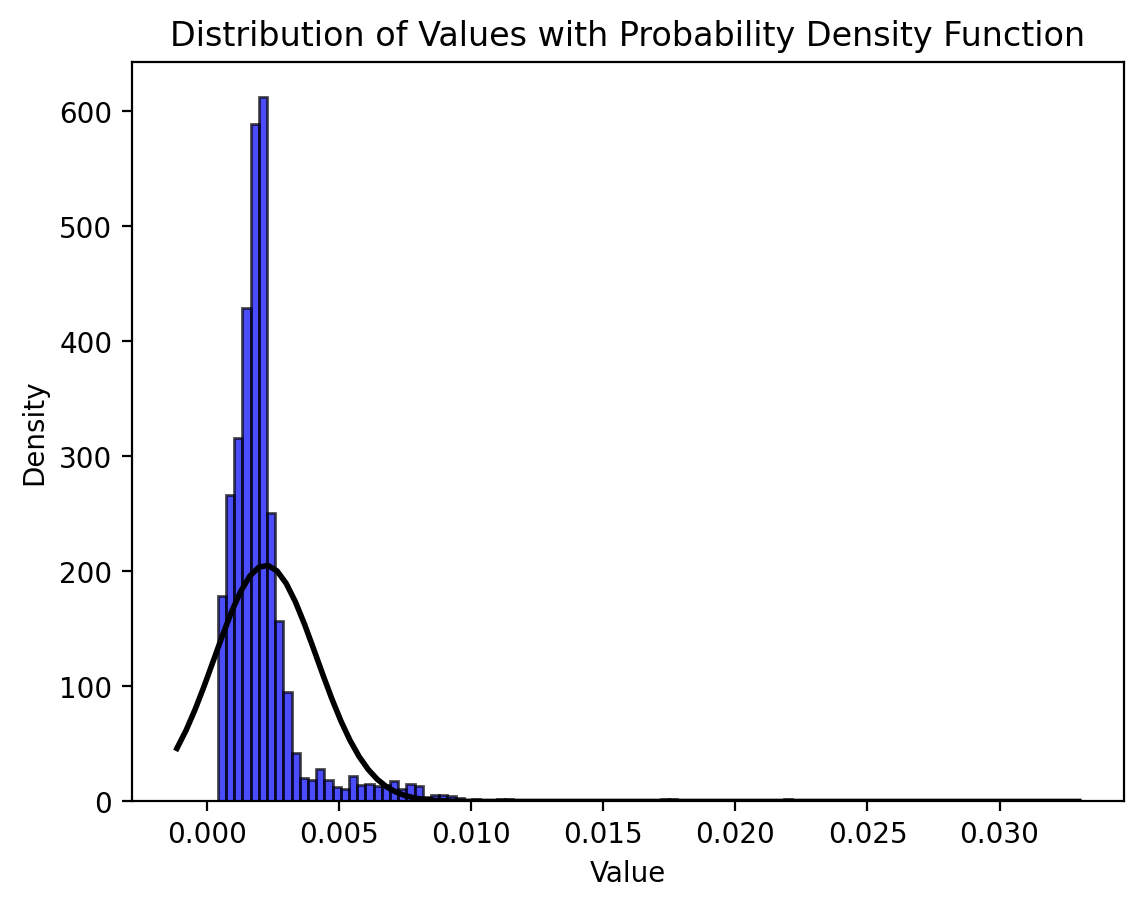

In [60]:
get_stat(images_mse_norm)

Запускаем тест, в котором собираем массив с предиктами

In [61]:
labels_tar = []
labels_pred = []

with torch.no_grad():
    for img, img_name, label in test_dataloader:
        original_images = img.to(device)
        reconstructed_images = model(original_images)
        
        for i in range(len(original_images)):
            mse = calculate_mse(original_images[i], reconstructed_images[i])
            
            if (mse > MIN_MSE_PROL and mse < MIN_MSE_TRASH):
                label_pred = 1
            else:
                label_pred = 0
                
            
            labels_tar.append(label[i])
            labels_pred.append(label_pred)

Смотрим метрики

In [62]:
labels_tar = torch.tensor(labels_tar)
labels_pred = torch.tensor(labels_pred)

TP = torch.sum((labels_pred == 1) & (labels_tar == 1)).item()
TN = torch.sum((labels_pred == 0) & (labels_tar == 0)).item()
FP = torch.sum((labels_pred == 1) & (labels_tar == 0)).item()
FN = torch.sum((labels_pred == 0) & (labels_tar == 1)).item()

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

print("True Positive Rate (TPR):", TPR)
print("True Negative Rate (TNR):", TNR)

True Positive Rate (TPR): 0.9224806201550387
True Negative Rate (TNR): 0.9107776261937244
